# 2. HMean Calculation for Text Detection & Spotting Tasks


In this notebook, we will learn how the evaluation metrics (IoU, HMean, Precision, and Recall) for text detection and spotting are computed. We will first install and import the necessary libraries; then go through the code for the evaluation methods. Lastly, we will examine examples of how the evaluation is carried out and obtain insights into each metric's measures.

**Table of Contents**

1. [Installation](#installation)
2. [Evaluation & Helper Methods](#evaluation--helper-methods)
3. [Evaluation Examples](#evaluation-examples)

Get your seatbelt on and let's get started! 🔥⭐


<a name="installation"></a>
## Installation

In [1]:
!pip install numpy
!pip install Polygon3
!pip install Pillow
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for Polygon3: filename=Polygon3-3.0.9.1-cp310-cp310-linux_x86_64.whl size=119439 sha256=53ce5f851a6c2b9b59d9a62c59e13bde6749337502fe98b81ad1c991f11d29d6
  Stored in directory: /root/.cache/pip/wheels/d8/b7/f6/b4e24f56a1cc9856dca98cc2fdc3915d7649b39b62f3dbca9e
Successfully built Polygon3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a name="evaluation--helper-methods"></a>
## Evaluation & Helper Methods

In [2]:
from collections import namedtuple
import numpy as np
import Polygon as plg
import cv2
from typing import Dict, List
from google.colab.patches import cv2_imshow
from collections import defaultdict

In [3]:
def evaluation(gt_dict: Dict[str, List], det_dict: Dict[str, List], eval_config: Dict):
    """
    Method evaluate_method: evaluate method and returns the results
        Results. Dictionary with the following values:
        - method (required)  Global method metrics. Ex: { 'Precision':0.8,'Recall':0.9 }
        - samples (optional) Per sample metrics. Ex: {'sample1' : { 'Precision':0.8,'Recall':0.9 } , 'sample2' : { 'Precision':0.8,'Recall':0.9 }
    """

    def polygon_from_points(points):
        """
        Returns a Polygon object to use with the Polygon2 class from a list of 8 points: x1,y1,x2,y2,x3,y3,x4,y4
        """
        num_points = len(points)
        # resBoxes=np.empty([1,num_points],dtype='int32')
        resBoxes=np.empty([1,num_points],dtype='float32')
        for inp in range(0, num_points, 2):
            resBoxes[0, inp//2] = float(points[inp])
            resBoxes[0, inp//2+num_points//2] = float(points[inp+1])
        pointMat = resBoxes[0].reshape([2,num_points//2]).T
        return plg.Polygon(pointMat)

    def get_union(pD,pG):
        areaA = pD.area()
        areaB = pG.area()
        return areaA + areaB - get_intersection(pD, pG)

    def get_intersection_over_union(pD,pG):
        try:
            return get_intersection(pD, pG) / get_union(pD, pG)
        except:
            return 0

    def funcCt(x):
        if x<=0.01:
            return 1
        else:
            return 1-x

    def funcOt(x):
        if x<=0.01:
            return 1
        else:
            return 1-x

    def get_text_intersection_over_union_recall(pD, pG):
        '''
        Ct (cut): Area of ground truth that is not covered by detection bounding box.
        '''
        try:
            intersection = get_intersection(pD, pG)
            union = get_union(pD, pG)
            Ct = pG.area() - intersection
            assert(Ct>=0 and Ct<=pG.area()), 'Invalid Ct value'
            assert(pG.area()>0), 'Invalid Gt'

            tiou_recall_str = f'{Ct}_{pG.area()}_{intersection}_{union}'
            return (intersection * funcCt(Ct*1.0/pG.area())) / union, tiou_recall_str
        except Exception as e:
            return 0


    def get_text_intersection_over_union_precision(pD, pG, gtNum, gtPolys, gtDontCarePolsNum):
        '''
        Ot: Outlier gt area
        '''
        Ot = 0
        try:
            inside_pG = pD & pG
            gt_union_inside_pD = None
            gt_union_inside_pD_and_pG = None
            count_initial = 0
            for i in range(len(gtPolys)):
                if i!= gtNum and gtNum not in gtDontCarePolsNum: # ignore don't care regions
                    if not get_intersection(pD, gtPolys[i]) == 0:
                        if count_initial == 0:
                            # initial
                            gt_union_inside_pD = gtPolys[i]
                            gt_union_inside_pD_and_pG = inside_pG & gtPolys[i]
                            count_initial = 1
                            continue
                        gt_union_inside_pD = gt_union_inside_pD | gtPolys[i]
                        inside_pG_i = inside_pG & gtPolys[i]
                        gt_union_inside_pD_and_pG = gt_union_inside_pD_and_pG | inside_pG_i

            if not gt_union_inside_pD == None:
                pD_union_with_other_gt = pD & gt_union_inside_pD
                Ot = pD_union_with_other_gt.area() - gt_union_inside_pD_and_pG.area()
                if Ot <=1.0e-10:
                    Ot = 0
            else:
                Ot = 0

            assert(Ot>=0 and Ot<=pD.area()+0.001), 'Invalid Ot value: '+str(Ot)+' '+str(pD.area())
            assert(pD.area()>0), 'Invalid pD: '+str(pD.area())

            intersection = get_intersection(pD, pG)
            union = get_union(pD, pG)
            tiou_precision_str = f'{Ot}_{pD.area()}_{intersection}_{union}'
            return (intersection * funcOt(Ot*1.0/pD.area())) / union, tiou_precision_str
        except Exception as e:
            print(e)
            return 0


    def get_intersection(pD,pG):
        pInt = pD & pG
        if len(pInt) == 0:
            return 0
        return pInt.area()

    perSampleMetrics = {}

    matchedSum = 0
    matchedSum_iou = 0
    matchedSum_tiouGt = 0
    matchedSum_tiouDt = 0
    matchedSum_cutGt = 0
    matchedSum_coverOtherGt = 0

    numGlobalCareGt = 0
    numGlobalCareDet = 0

    totalNumGtPols = 0
    totalNumDetPols = 0

    # loop through each image id
    for gt_key, gt_val in gt_dict.items():
        recall = 0
        precision = 0
        hmean = 0

        detMatched = 0
        detMatched_iou = 0
        detMatched_tiouGt = 0
        detMatched_tiouDt = 0
        detMatched_cutGt = 0
        detMatched_coverOtherGt = 0

        iouMat = np.empty([1,1])

        gtPols = []
        detPols = []

        gtPolPoints = []
        detPolPoints = []

        #Array of Ground Truth Polygons' keys marked as don't Care
        gtDontCarePolsNum = []
        #Array of Detected Polygons' matched with a don't Care GT
        detDontCarePolsNum = []

        pairs = []
        detMatchedNums = []

        if eval_config["WORD_SPOTTING"]:
            gtTrans = []
            detTrans = []

        evaluationLog = ""

        for n in range(len(gt_val)):
            dict_entry = gt_val[n]

            points = []
            for point in dict_entry['points']:
                points.append(point[0])
                points.append(point[1])

            transcription = dict_entry['transcription']

            if eval_config["WORD_SPOTTING"]:
                # append ground-truth transcript
                gtTrans.append(transcription)

            dontCare = transcription == "###"
            gtPol = polygon_from_points(points)
            gtPols.append(gtPol)
            gtPolPoints.append(points)
            if dontCare:
                gtDontCarePolsNum.append( len(gtPols)-1 )

        evaluationLog += "GT polygons: " + str(len(gtPols)) + (" (" + str(len(gtDontCarePolsNum)) + " don't care)\n" if len(gtDontCarePolsNum)>0 else "\n")

        # if there's bounding box in prediction
        if gt_key in det_dict.keys():

            det_val = det_dict[gt_key]
            for n in range(len(det_val)):
                dict_entry = det_val[n]

                points = []
                for point in dict_entry['points']:
                    points.append(point[0])
                    points.append(point[1])

                if eval_config["WORD_SPOTTING"]:
                    detTrans.append(dict_entry['transcription'])

                detPol = polygon_from_points(points)
                detPols.append(detPol)
                detPolPoints.append(points)
                if len(gtDontCarePolsNum)>0 :
                    for dontCarePol in gtDontCarePolsNum:
                        dontCarePol = gtPols[dontCarePol]
                        intersected_area = get_intersection(dontCarePol,detPol)
                        pdDimensions = detPol.area()
                        precision = 0 if pdDimensions == 0 else intersected_area / pdDimensions
                        if (precision > eval_config['AREA_PRECISION_CONSTRAINT'] ):
                            detDontCarePolsNum.append( len(detPols)-1 )
                            break

            evaluationLog += "DET polygons: " + str(len(detPols)) + (" (" + str(len(detDontCarePolsNum)) + " don't care)\n" if len(detDontCarePolsNum)>0 else "\n")

            if len(gtPols)>0 and len(detPols)>0:
                #Calculate IoU and precision matrixs
                outputShape=[len(gtPols),len(detPols)]
                iouMat = np.empty(outputShape)
                gtRectMat = np.zeros(len(gtPols),np.int8)
                detRectMat = np.zeros(len(detPols),np.int8)
                tiouRecallMat = np.empty(outputShape)
                tiouRecallStrMat = defaultdict(dict)
                tiouPrecisionMat = np.empty(outputShape)
                tiouPrecisionStrMat = defaultdict(dict)
                tiouGtRectMat = np.zeros(len(gtPols),np.int8)
                tiouDetRectMat = np.zeros(len(detPols),np.int8)
                for gtNum in range(len(gtPols)):
                    for detNum in range(len(detPols)):
                        pG = gtPols[gtNum]
                        pD = detPols[detNum]
                        iouMat[gtNum,detNum] = get_intersection_over_union(pD,pG)
                        tiouRecallMat[gtNum,detNum], tiouRecallStrMat[gtNum][detNum] = get_text_intersection_over_union_recall(pD,pG)
                        tiouPrecisionMat[gtNum,detNum], tiouPrecisionStrMat[gtNum][detNum] = get_text_intersection_over_union_precision(pD, pG, gtNum, gtPols, gtDontCarePolsNum)

                for gtNum in range(len(gtPols)):
                    for detNum in range(len(detPols)):
                        if gtRectMat[gtNum] == 0 and detRectMat[detNum] == 0 and gtNum not in gtDontCarePolsNum and detNum not in detDontCarePolsNum :
                            if iouMat[gtNum,detNum]>eval_config['IOU_CONSTRAINT']:
                                gtRectMat[gtNum] = 1
                                detRectMat[detNum] = 1
                                if eval_config["WORD_SPOTTING"]:
                                      correct = (
                                          str(gtTrans[gtNum]).upper()
                                          == str(detTrans[detNum]).upper()
                                      )
                                      if correct:
                                          detMatched += 1
                                          detMatched_iou += iouMat[gtNum,detNum]
                                          detMatched_tiouGt += tiouRecallMat[gtNum,detNum]
                                          detMatched_tiouDt += tiouPrecisionMat[gtNum,detNum]
                                          if iouMat[gtNum,detNum] != tiouRecallMat[gtNum,detNum]:
                                              detMatched_cutGt +=1
                                          if iouMat[gtNum,detNum] != tiouPrecisionMat[gtNum,detNum]:
                                              detMatched_coverOtherGt +=1
                                          pairs.append({'gt':gtNum,'det':detNum})
                                          detMatchedNums.append(detNum)
                                          evaluationLog += "Match GT #" + str(gtNum) + " with Det #" + str(detNum) + " trans. correct: " + str(correct) + "\n"
                                else:
                                  detMatched += 1
                                  detMatched_iou += iouMat[gtNum,detNum]
                                  detMatched_tiouGt += tiouRecallMat[gtNum,detNum]
                                  detMatched_tiouDt += tiouPrecisionMat[gtNum,detNum]
                                  if  iouMat[gtNum,detNum] != tiouRecallMat[gtNum,detNum]:
                                      detMatched_cutGt +=1
                                  if  iouMat[gtNum,detNum] != tiouPrecisionMat[gtNum,detNum]:
                                      detMatched_coverOtherGt +=1
                                  pairs.append({'gt':gtNum,'det':detNum})
                                  detMatchedNums.append(detNum)
                                  evaluationLog += "Match GT #" + str(gtNum) + " with Det #" + str(detNum) + "\n"

        numGtCare = (len(gtPols) - len(gtDontCarePolsNum))
        numDetCare = (len(detPols) - len(detDontCarePolsNum))
        if numGtCare == 0:
            recall = float(1)
            precision = float(0) if numDetCare >0 else float(1)
            iouRecall = float(1)
            iouPrecision = float(0) if numDetCare > 0 else float(1)
            tiouRecall = float(1)
            tiouPrecision = float(0) if numDetCare >0 else float(1)
        else:
            recall = float(detMatched) / numGtCare
            precision = 0 if numDetCare==0 else float(detMatched) / numDetCare
            iouRecall = float(detMatched_iou) / numGtCare
            iouPrecision = 0 if numDetCare==0 else float(detMatched_iou) / numDetCare
            tiouRecall = float(detMatched_tiouGt) / numGtCare
            tiouPrecision = 0 if numDetCare==0 else float(detMatched_tiouDt) / numDetCare

        hmean = 0 if (precision + recall)==0 else 2.0 * precision * recall / (precision + recall)
        tiouHmean = 0 if (tiouPrecision + tiouRecall)==0 else 2.0 * tiouPrecision * tiouRecall / (tiouPrecision + tiouRecall)
        iouHmean = 0 if (iouPrecision + iouRecall)==0 else 2.0 * iouPrecision * iouRecall / (iouPrecision + iouRecall)

        matchedSum += detMatched
        matchedSum_iou += detMatched_iou
        matchedSum_tiouGt += detMatched_tiouGt
        matchedSum_tiouDt += detMatched_tiouDt
        matchedSum_cutGt += detMatched_cutGt
        matchedSum_coverOtherGt += detMatched_coverOtherGt
        numGlobalCareGt += numGtCare
        numGlobalCareDet += numDetCare

        perSampleMetrics[gt_key] = {
            'precision':precision,
            'recall':recall,
            'hmean':hmean,
            'iouPrecision':iouPrecision,
            'iouRecall':iouRecall,
            'iouHmean':iouHmean,
            'tiouPrecision':tiouPrecision,
            'tiouRecall':tiouRecall,
            'tiouHmean':tiouHmean,
            'pairs':pairs,
            'iouMat':[] if len(detPols)>100 else iouMat.tolist(),
            'tiouRecallMat':[] if len(detPols)>100 else tiouRecallMat.tolist(),
            'tiouRecallStrMat':[] if len(detPols)>100 else tiouRecallStrMat,
            'tiouPrecisionMat':[] if len(detPols)>100 else tiouPrecisionMat.tolist(),
            'tiouPrecisionStrMat':[] if len(detPols)>100 else tiouPrecisionStrMat,
            'gtPolPoints':gtPolPoints,
            'detPolPoints':detPolPoints,
            'gtDontCare':gtDontCarePolsNum,
            'detDontCare':detDontCarePolsNum,
            'eval_config': eval_config,
            'evaluationLog': evaluationLog
        }

        if eval_config["WORD_SPOTTING"]:
                perSampleMetrics[gt_key]["gtTrans"] = gtTrans
                perSampleMetrics[gt_key]["detTrans"] = detTrans

        try:
            totalNumGtPols += len(gtPols)
            totalNumDetPols += len(detPols)
        except Exception as e:
            raise e

    # print(f'num_gt: {numGlobalCareGt}, num_det: {totalNumDetPols}')
    methodRecall = 0 if numGlobalCareGt == 0 else float(matchedSum)/numGlobalCareGt
    methodPrecision = 0 if numGlobalCareDet == 0 else float(matchedSum)/numGlobalCareDet
    methodHmean = 0 if methodRecall + methodPrecision==0 else 2* methodRecall * methodPrecision / (methodRecall + methodPrecision)


    methodRecall_iou = 0 if numGlobalCareGt == 0 else float(matchedSum_iou)/numGlobalCareGt
    methodPrecision_iou = 0 if numGlobalCareDet == 0 else float(matchedSum_iou)/numGlobalCareDet
    iouMethodHmean = 0 if methodRecall_iou + methodPrecision_iou==0 else 2* methodRecall_iou * methodPrecision_iou / (methodRecall_iou + methodPrecision_iou)

    methodRecall_tiouGt = 0 if numGlobalCareGt == 0 else float(matchedSum_tiouGt)/numGlobalCareGt
    methodPrecision_tiouDt = 0 if numGlobalCareDet == 0 else float(matchedSum_tiouDt)/numGlobalCareDet
    tiouMethodHmean = 0 if methodRecall_tiouGt + methodPrecision_tiouDt==0 else 2* methodRecall_tiouGt * methodPrecision_tiouDt / (methodRecall_tiouGt + methodPrecision_tiouDt)

    methodMetrics = {'precision':methodPrecision, 'recall':methodRecall,'hmean': methodHmean}
    iouMethodMetrics = {'iouPrecision':methodPrecision_iou, 'iouRecall':methodRecall_iou,'iouHmean': iouMethodHmean }
    tiouMethodMetrics = {'tiouPrecision':methodPrecision_tiouDt, 'tiouRecall':methodRecall_tiouGt,'tiouHmean': tiouMethodHmean }

    # print('matchedSum: ', matchedSum, 'matchedSum_cutGt: ', matchedSum_cutGt, 'cut_Rate: ', round(matchedSum_cutGt*1.0/matchedSum, 3), 'matchedSum_coverOtherGt: ', matchedSum_coverOtherGt, 'cover_Outlier_Rate: ', round(matchedSum_coverOtherGt*1.0/matchedSum, 3))
    # print('Origin:')
    # print(f"recall: {round(methodRecall,3)}, precision: {round(methodPrecision,3)}, hmean: {round(methodHmean,3)}")
    # print('SIoU-metric:')
    # print(f"iouRecall: {round(methodRecall_iou,3)}, iouPrecision: {round(methodPrecision_iou,3)}, iouHmean: {round(iouMethodHmean,3)}")
    # print('TIoU-metric:')
    # print(f"tiouRecall: {round(methodRecall_tiouGt,3)}, tiouPrecision: {round(methodPrecision_tiouDt,3)}, tiouHmean: {round(tiouMethodHmean,3)}")

    resDict = {'calculated':True,'Message':'','method': methodMetrics,'per_sample': perSampleMetrics, 'iouMethod': iouMethodMetrics, 'tiouMethod': tiouMethodMetrics}


    return resDict

In [4]:
def draw_img(gtPointsList: List, detPointsList: List, down_scale: int, img_w: int, img_h: int):
    blank_image = np.ones((img_h, img_w, 3), np.uint8) * 255

    text_offset = 2

    for ann in gtPointsList:
      scaled_points = [y/down_scale for x in ann['points'] for y in x]
      cv2_points = np.array(scaled_points, np.int32).reshape(-1,1,2)
      trans = ann['transcription']
      if trans == '###':
        outline_color = (255, 0, 0)
      else:
        outline_color = (0, 255, 0)

      cv2.polylines(blank_image, [cv2_points], isClosed=True, color=outline_color, thickness=2)
      cv2.putText(blank_image, trans, (int(scaled_points[0]), int(scaled_points[1])), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=outline_color, thickness=2, lineType=cv2.LINE_AA)

    for ann in detPointsList:
      scaled_points = [y/down_scale for x in ann['points'] for y in x]
      cv2_points = np.array(scaled_points, np.int32).reshape(-1,1,2)
      trans = ann['transcription']
      outline_color = (0, 0, 255)
      cv2.polylines(blank_image, [cv2_points], isClosed=True, color=outline_color, thickness=2)
      cv2.putText(blank_image, trans, (int(scaled_points[0]), int(scaled_points[1])), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=outline_color, thickness=2, lineType=cv2.LINE_AA)

    return blank_image

In [5]:
def format_dict(resDict: Dict[str, List], img_id: str, print_details: bool):
    """Extract per-sample metric from the resDict based on img_id

    Args:
        resDict (Dict[str, List]): Result dictionary from `evaluation()`
        img_id (str): Image to be investigated

    Returns:
        matched_str (str): Matched GT bounding box index and predicted bounding box index and the respective IoU
        ignore_str (str): Ignored GT bounding box index and predicted bounding box index and the respective IoU
        unmatched_str (str): Unmatch GT bounding box index and predicted bounding box index and the respective IoU
    """
    matched_str = ""
    ignore_str = ""
    unmatched_str = ""
    matched_pairs = resDict["per_sample"][img_id]["pairs"]

    discovered_gts = []
    discovered_dets = []
    undiscovered_gts = []
    undiscovered_dets = []

    for pair in matched_pairs:
        gt_id = pair["gt"]
        det_id = pair["det"]
        matched_str += (
            f"\nMATCHED GT {gt_id} and MATCHED PRED {det_id} IoU:"
            f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}, "
            f"TIoU_Recall: {round(resDict['per_sample'][img_id]['tiouRecallMat'][gt_id][det_id], 2)}, "
            f"TIoU_Precision: {round(resDict['per_sample'][img_id]['tiouPrecisionMat'][gt_id][det_id], 2)}\n"
        )
        if print_details:
          tiou_recall_str = resDict['per_sample'][img_id]['tiouRecallStrMat'][gt_id][det_id]
          recall_str_list = tiou_recall_str.strip().split('_')
          ct = recall_str_list[0]
          gt_area = recall_str_list[1]
          rec_intersect_area = recall_str_list[2]
          rec_union_area = recall_str_list[3]

          tiou_precision_str = resDict['per_sample'][img_id]['tiouPrecisionStrMat'][gt_id][det_id]
          prec_str_list = tiou_precision_str.strip().split('_')
          ot = prec_str_list[0]
          pred_area = prec_str_list[1]
          prec_intersect_area = prec_str_list[2]
          prec_union_area = prec_str_list[3]

          assert rec_intersect_area == prec_intersect_area
          assert rec_union_area == prec_union_area
          matched_str += (
            f"Area of GT #{gt_id} is {gt_area}, Area of Pred #{det_id} is {pred_area},\n"
            f"Intersection of (GT, Pred) is {rec_intersect_area},\n"
            f"Union of (GT, Pred) is {rec_union_area},\n"
            f"C_t is {ct} and O_t is {ot}\n"
          )
        discovered_gts.append(gt_id)
        discovered_dets.append(det_id)

    for gt_id, det_id in zip(
        resDict["per_sample"][img_id]["gtDontCare"],
        resDict["per_sample"][img_id]["detDontCare"],
    ):
        ignore_str += (
            f"IGNORED GT {gt_id} and IGNORED PRED {det_id} IoU:"
            f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}\n"
        )
        discovered_gts.append(gt_id)
        discovered_dets.append(det_id)

    for gt_id in range(len(resDict["per_sample"][img_id]["gtPolPoints"])):
        if gt_id not in discovered_gts:
            undiscovered_gts.append(gt_id)

    for det_id in range(len(resDict["per_sample"][img_id]["detPolPoints"])):
        if det_id not in discovered_dets:
            undiscovered_dets.append(det_id)

    for gt_id in undiscovered_gts:
        for det_id in undiscovered_dets:
            unmatched_str += (
                f"UNMATCHED GT {gt_id} and UNMATCHED PRED {det_id} IoU:"
                f" {round(resDict['per_sample'][img_id]['iouMat'][gt_id][det_id], 2)}\n"
            )

    return matched_str, ignore_str, unmatched_str

<a name="evaluation-examples"></a>
## Evaluation Examples

### Example 1 - Cutting Cases

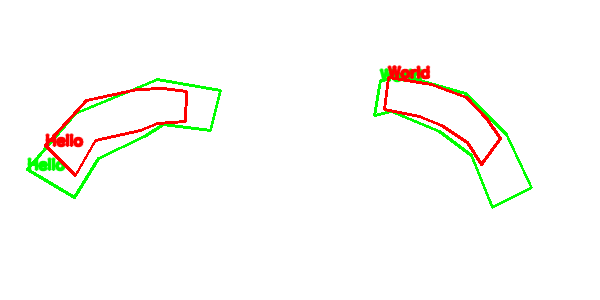

---Overall Metric---
Precision: 1.0, Recall: 1.0, HMean: 1.0

TIoU_Precision: 0.55, TIoU_Recall: 0.3, TIoU_HMean: 0.39

---Per Sample Metric---
---Matched---

MATCHED GT 0 and MATCHED PRED 0 IoU: 0.55, TIoU_Recall: 0.31, TIoU_Precision: 0.55
Area of GT #0 is 9192.5, Area of Pred #0 is 5496.0,
Intersection of (GT, Pred) is 5204.561395126612,
Union of (GT, Pred) is 9483.938604873387,
C_t is 3987.9386048733877 and O_t is 0

MATCHED GT 1 and MATCHED PRED 1 IoU: 0.55, TIoU_Recall: 0.3, TIoU_Precision: 0.55
Area of GT #1 is 7541.0, Area of Pred #1 is 4127.5,
Intersection of (GT, Pred) is 4125.619811724435,
Union of (GT, Pred) is 7542.880188275565,
C_t is 3415.380188275565 and O_t is 0



In [6]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList =	[{"transcription": "Hello", "points": [[27, 169], [75, 113], [126, 92], [157, 79], [220, 90], [210, 130], [163, 124], [144, 136], [98, 158], [74, 197]]},
                  {"transcription": "World", "points": [[380, 80], [402, 75], [465, 93], [506, 134], [531, 187], [492, 207], [471, 155], [439, 131], [391, 111], [374, 115]]}]

detPointsList =	[{"transcription": "Hello", "points": [[45, 145], [86, 100], [137, 89], [163, 88], [186, 91], [185, 121], [157, 123], [140, 130], [95, 140], [75, 175]]},
{"transcription": "World", "points": [[388, 77], [431, 84], [466, 97], [486, 118], [500, 138], [481, 164], [467, 142], [441, 125], [419, 116], [384, 109]]}]

img_id = "img_1"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, down_scale=1, img_w=600, img_h=300)
cv2_imshow(demo_img)

resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)}, TIoU_HMean:"
    f" {round(tiouHmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id, print_details=True)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

### Example 2 - Outlier Cases

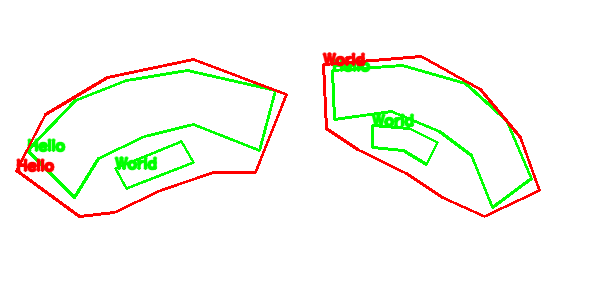

---Overall Metric---
Precision: 0.5, Recall: 0.25, HMean: 0.33

TIoU_Precision: 0.25, TIoU_Recall: 0.13, TIoU_HMean: 0.17

---Per Sample Metric---
---Matched---

MATCHED GT 0 and MATCHED PRED 0 IoU: 0.53, TIoU_Recall: 0.53, TIoU_Precision: 0.5
Area of GT #0 is 14303.5, Area of Pred #0 is 26833.5,
Intersection of (GT, Pred) is 14303.5,
Union of (GT, Pred) is 26833.5,
C_t is 0.0 and O_t is 1668.0

---Unmatched---
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 1 IoU: 0.53
UNMATCHED GT 3 and UNMATCHED PRED 1 IoU: 0.07



In [7]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList =	[{"transcription": "Hello", "points": [[27, 150], [75, 100], [126, 80], [187, 70], [275, 90], [259, 150], [193, 124], [144, 136], [98, 158], [74, 197]]},
{"transcription": "World", "points": [[115, 168], [181, 141], [193, 162], [126, 188]]},
{"transcription": "Hello", "points": [[332, 70], [402, 65], [465, 83], [506, 120], [531, 178], [492, 207], [471, 155], [439, 131], [391, 111], [334, 119]]},
{"transcription": "World", "points": [[372, 125], [409, 128], [437, 142], [426, 164], [403, 150], [372, 147]]}]

detPointsList =	[{"transcription": "Hello", "points": [[16, 170], [45, 114], [107, 77], [193, 59], [286, 94], [255, 172], [213, 172], [160, 190], [114, 212], [79, 216]]},
{"transcription": "World", "points": [[323, 64], [421, 56], [480, 89], [520, 137], [539, 190], [484, 216], [442, 197], [406, 173], [357, 149], [326, 128]]}]
img_id = "img_2"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, down_scale=1, img_w=600, img_h=300)
cv2_imshow(demo_img)

resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)}, TIoU_HMean:"
    f" {round(tiouHmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id, print_details=True)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)

### Example 3 - Cutting & Outlier Cases

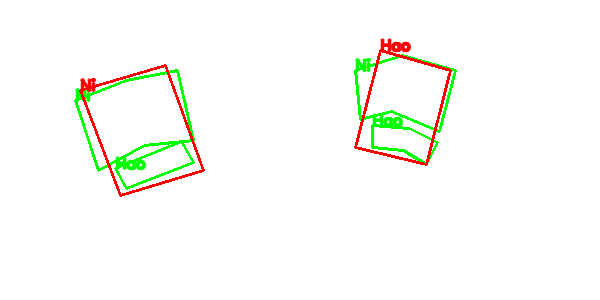

---Overall Metric---
Precision: 0.5, Recall: 0.25, HMean: 0.33

TIoU_Precision: 0.23, TIoU_Recall: 0.12, TIoU_HMean: 0.16

---Per Sample Metric---
---Matched---

MATCHED GT 0 and MATCHED PRED 0 IoU: 0.56, TIoU_Recall: 0.48, TIoU_Precision: 0.47
Area of GT #0 is 7237.5, Area of Pred #0 is 9795.0,
Intersection of (GT, Pred) is 6137.106696796706,
Union of (GT, Pred) is 10895.393303203295,
C_t is 1100.3933032032937 and O_t is 1667.9043303121853

---Unmatched---
UNMATCHED GT 1 and UNMATCHED PRED 1 IoU: 0.0
UNMATCHED GT 2 and UNMATCHED PRED 1 IoU: 0.52
UNMATCHED GT 3 and UNMATCHED PRED 1 IoU: 0.19



In [8]:
eval_config = {
    "IOU_CONSTRAINT": 0.5,
    "AREA_PRECISION_CONSTRAINT": 0.5,
    "WORD_SPOTTING": True,
}

gtPointsList =	[{"transcription": "Ni", "points": [[75, 100], [126, 80], [177, 70], [193, 140], [144, 145], [98, 170]]},
{"transcription": "Hao", "points": [[115, 168], [181, 141], [193, 162], [126, 188]]},
{"transcription": "Ni", "points": [[355, 70], [402, 55], [455, 70], [439, 131], [391, 111], [360, 119]]},
{"transcription": "Hao", "points": [[372, 125], [409, 128], [437, 142], [426, 164], [403, 150], [372, 147]]}]

detPointsList =	[{"transcription": "Ni", "points": [[80, 90], [165, 65], [203, 170], [120, 195]]},
{"transcription": "Hao", "points": [[380, 50], [450, 70], [426, 164], [355, 147]]}]
img_id = "img_2"
gt_dict = {img_id: gtPointsList}
det_dict = {img_id: detPointsList}

demo_img = draw_img(gtPointsList, detPointsList, down_scale=1, img_w=600, img_h=300)
cv2_imshow(demo_img)

resDict = evaluation(gt_dict, det_dict, eval_config)
precision, recall, hmean = (
    resDict["method"]["precision"],
    resDict["method"]["recall"],
    resDict["method"]["hmean"],
)
tiouPrecision, tiouRecall, tiouHmean = (
    resDict["tiouMethod"]["tiouPrecision"],
    resDict["tiouMethod"]["tiouRecall"],
    resDict["tiouMethod"]["tiouHmean"],
)

print("---Overall Metric---")
print(
    f"Precision: {round(precision, 2)}, Recall: {round(recall, 2)}, HMean:"
    f" {round(hmean, 2)}\n"
)
print(
    f"TIoU_Precision: {round(tiouPrecision, 2)}, TIoU_Recall: {round(tiouRecall, 2)}, TIoU_HMean:"
    f" {round(tiouHmean, 2)}\n"
)

matched_str, ignore_str, unmatched_str = format_dict(resDict, img_id, print_details=True)

print("---Per Sample Metric---")

if matched_str != "":
    print("---Matched---")
    print(matched_str)

if ignore_str != "":
    print("---Ignored---")
    print(ignore_str)

if unmatched_str != "":
    print("---Unmatched---")
    print(unmatched_str)